In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pomegranate import *
from scipy import stats

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine
from model.featureConfig import FeatureConfig_G3
#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

## Configuration and Data Loading

In [2]:
# Setup configuration
cfg = config.ResearchConfig_MonOnly
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:03<00:00, 840.23it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [3]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.
+ Add feature: mark.
Aggregate data over customer months.


100%|██████████| 49/49 [00:27<00:00,  1.81it/s]


In [4]:
df_whizz1 = data_engine.df_whizz_

## Groups

In [5]:
mask_churn = df_whizz1.churn==1

mask_inactive = df_whizz1.active==0

print('Churn rate for inactive subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_inactive&mask_churn].shape[0]/df_whizz1[mask_inactive].shape[0]*100))
print('Churn rate for active subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_inactive&mask_churn].shape[0]/df_whizz1[~mask_inactive].shape[0]*100))

mask_noassess = (df_whizz1.assess==0) & (df_whizz1.active==1)
print('Churn rate for subscribers having no assessment = {:.2f}%.'.\
      format(df_whizz1[mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[mask_noassess&~mask_inactive].shape[0]*100))
print('Churn rate for subscribers having assessment = {:.2f}%.'.\
      format(df_whizz1[~mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[~mask_noassess&~mask_inactive].shape[0]*100))

mask_fine = ~mask_inactive & ~mask_noassess

print('Churn rate for good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_fine&mask_churn].shape[0]/\
             df_whizz1[mask_fine].shape[0]*100))
print('Churn rate for not good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_fine&mask_churn].shape[0]/\
             df_whizz1[~mask_fine].shape[0]*100))
print('Churn rate for all subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_churn].shape[0]/\
             df_whizz1.shape[0]*100))

Churn rate for inactive subscribers = 22.99%.
Churn rate for active subscribers = 10.46%.
Churn rate for subscribers having no assessment = 16.94%.
Churn rate for subscribers having assessment = 10.21%.
Churn rate for good-quality subscribers = 10.21%.
Churn rate for not good-quality subscribers = 22.61%.
Churn rate for all subscribers = 14.96%.


In [6]:
df_whizz_fine = df_whizz1[mask_fine]

## Illustration of benefits of data transformation

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


0.12014020401599161


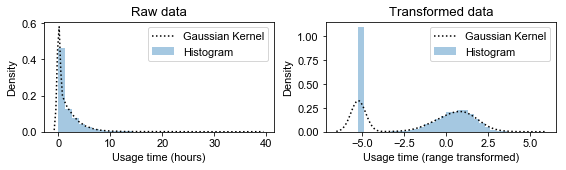

In [7]:
x = df_whizz1['usage'].values + 1
x /= 3600.

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 11

fig = plt.figure(figsize=(8,2.5))
ax = fig.add_subplot(121)
sns.distplot(x, bins=30, kde=True, 
             kde_kws={'linestyle':':', 'color':'k', 'label':'Gaussian Kernel'}, 
             hist_kws={'label':'Histogram'})
ax.set_xlabel('Usage time (hours)')
ax.set_ylabel('Density')
ax.set_title('Raw data')
ax.set_rasterized(True)

ax = fig.add_subplot(122)
xt, l = stats.boxcox(x)
sns.distplot(xt, bins=30, kde=True, 
             kde_kws={'linestyle':':', 'color':'k', 'label':'Gaussian Kernel'},
             hist_kws={'label':'Histogram'})
ax.set_xlabel('Usage time (range transformed)')
ax.set_ylabel('Density')
ax.set_title('Transformed data')
ax.set_rasterized(True)

plt.legend()
plt.tight_layout()
plt.savefig('../../../Result/Plot/BoxCoxTransformation.eps', dpi=500)

print(l)

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


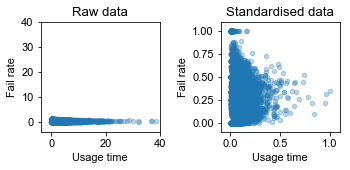

In [8]:
x1 = df_whizz_fine['usage'].values/3600.
x2 = df_whizz_fine.rate_fail.values

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 11

fig = plt.figure(figsize=(5,2.5))
ax = fig.add_subplot(121)
ax.scatter(x1, x2, alpha=0.3, s=20)
ax.set_xlim([-4,40])
ax.set_ylim([-4,40])
ax.set_xlabel('Usage time')
ax.set_ylabel('Fail rate')
ax.set_title('Raw data')
ax.set_rasterized(True)

X = np.vstack([x1, x2])
X = X.transpose()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
Xt = scaler.transform(X)

ax = fig.add_subplot(122)
ax.scatter(Xt[:,0], Xt[:,1], alpha=0.3, s=20)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_xlabel('Usage time')
ax.set_ylabel('Fail rate')
ax.set_title('Standardised data')
ax.set_rasterized(True)

plt.tight_layout()
plt.savefig('../../../Result/Plot/DataStandardisation.eps', dpi=500)

## Customer month independence

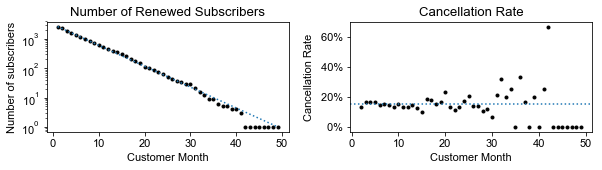

In [18]:
# Population
def survival_customer_month(df_subspt):
    survival_population = df_subspt.groupby('customer_month')['pupilId'].count()
    
    fig = plt.figure(figsize=(8.5,2.5))

    ax = fig.add_subplot(121)
    gmean_survival_rate =  (survival_population.values[-1] /\
       survival_population.values[0])**(1.0 / (survival_population.shape[0]-1))
    survival_theory = np.power(gmean_survival_rate, 
                               range(0, survival_population.shape[0])) *\
                                  survival_population.values[0]
    ax.plot(survival_population, 'ko', markersize=3)
    ax.plot(survival_population.index, survival_theory, ':')
    ax.set_title('Number of Renewed Subscribers')
    ax.set_xlabel('Customer Month')
    ax.set_ylabel('Number of subscribers')
    ax.set_yscale('log')

    ax = fig.add_subplot(122)
    ax.plot(-survival_population.pct_change(), 'ko', markersize=3)
    ax.axhline(y=1-gmean_survival_rate, linestyle=':')
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);
    ax.set_xlabel('Customer Month')
    ax.set_ylabel('Cancellation Rate')
    ax.set_title('Cancellation Rate')

    plt.tight_layout()
    plt.savefig('../../../Result/Plot/CancellationRate.eps', dpi=500)

survival_customer_month(df_subspt1)

## Distributions

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


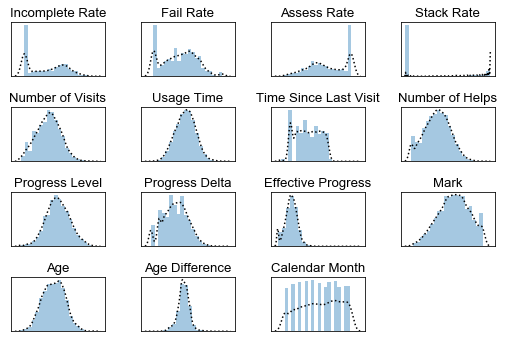

In [57]:
df_whizz_fine = df_whizz1[mask_fine]
df_whizz_fine.drop(columns=['active', 'assess', 'mark_incomplete'], inplace=True)

df_whizz_fine = df_whizz_fine.assign(effective_progress=df_whizz_fine.progress_delta/df_whizz_fine.usage*3600.)

ftr_list_independent = ['rate_incomplete_num',
                        'rate_fail',
                        'rate_assess',
                        'rate_stackDepth23_num', 
                       ]

ftr_list_multivariate = ['num_attempt',
                         'usage',
                         'last_access',
                         'sum_help',
                         'progress', 
                         'progress_delta',
                         'effective_progress', 
                         'mark_complete',
                         'age',
                         'age_diff',
                         'calendar_month',
                        ]

ftr_list = ftr_list_independent + ftr_list_multivariate

ftr_name_list = ['Incomplete Rate', 'Fail Rate', 'Assess Rate', 'Stack Rate',
                 'Number of Visits', 'Usage Time', 'Time Since Last Visit', 'Number of Helps',
                 'Progress Level', 'Progress Delta', 'Effective Progress', 'Mark',
                 'Age', 'Age Difference', 'Calendar Month',
                ]

def feature_distribution(df_whizz, ftr_list, n_col, configuration,
                         ftr_name_list,
                         transform=True, ftr_list_nontransform=[]):
    n_ftr = len(ftr_list)
    n_row = n_ftr // n_col
    n_row +=  n_ftr % n_col
    pos = range(1, n_ftr+1)
    
    warnings.filterwarnings('ignore')

    fig = plt.figure(figsize=(1.8*n_col, 1.2*n_row))
    for i, ftr in enumerate(ftr_list):
        ax = fig.add_subplot(n_row, n_col, pos[i])
        x = df_whizz[ftr].dropna().values # drop NaN for plotting
    
        if (ftr in ftr_list_nontransform) or (not transform):
            sns.distplot(x)
        else:
            # Box-cox transformation can only deal with positive valued data
            # May need to add positive constants to variables to ensure positivity
            if ftr == 'age_diff':
                x += 10.0
            else:
                x += 1
            xt, _ = stats.boxcox(x)
            sns.distplot(xt, bins=20, kde_kws={'linestyle':':', 'color':'k'})
        ax.set_title(ftr_name_list[i])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_rasterized(True)
    
    warnings.filterwarnings('default')

    plt.tight_layout()
    plt.savefig('../../../Result/Plot/FeatureDistribution.eps', dpi=500)

ftr_list_nontransform = []
feature_distribution(
    df_whizz_fine, ftr_list, 4, cfg, ftr_name_list,
    transform=True, ftr_list_nontransform=ftr_list_nontransform)

C:\Users\User\Anaconda3\lib\site-packages\seaborn\palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


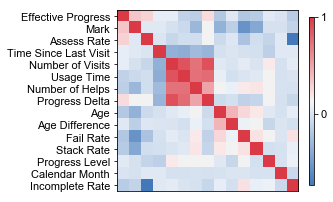

In [55]:
def feature_correlation(df_features, ftr_name_list, size=10):
    import scipy.cluster.hierarchy as sch

    X = df_features.corr().values
    d = sch.distance.pdist(X)       # vector of pairwise distances
    L = sch.linkage(d, method='complete')
    idx = sch.fcluster(L, 0.5*d.max(), 'distance')
    columns = [df_features.columns.tolist()[i] for i in list(np.argsort(idx))]
    ftr_name_list = [ftr_name_list[i] for i in list(np.argsort(idx))]
    df_features = df_features.reindex(columns, axis=1)

    corr = df_features.corr()
    plt.rcParams['font.family'] = 'arial'
    plt.rcParams['font.size'] = 11
    
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap=sns.diverging_palette(250, 10, as_cmap=True))
    #plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    
    plt.xticks([]);
    plt.yticks(range(len(corr.columns)), ftr_name_list);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.5)
    
    plt.tight_layout()
    plt.savefig('../../../Result/Plot/FeatureCorrelation.eps', dpi=500)

feature_correlation(df_whizz_fine[ftr_list], ftr_name_list, size=5)

## Independent features

In [58]:
def independent_component(ftr_str, hist_bin=35, plot=True):
    from sklearn.preprocessing import MinMaxScaler
    
    ftrConfig = FeatureConfig_G3()

    ftr_config = eval('ftrConfig.'+ftr_str)

    if plot:
        utility.plotlib.compare_transformed_singleValueRemoved(df_whizz_fine, ftr_str, 'min')
        
    # Define the data to be fitted
    x_raw = df_whizz_fine[ftr_str].values
    x = x_raw * ftr_config.multiplierPre
    x += ftr_config.shiftPre
    # Box-cox transform
    if ftr_config.bcTransform:
        xt, bc_param = stats.boxcox(x)
        x = xt
    x = x.reshape(-1,1)
    # Standardise
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    # Post-BoxCox transform
    x *= ftr_config.multiplierPost
    x += ftr_config.shiftPost

    # Define the list of distributions to be mixed
    distribution_list = ftr_config.distributionList

    gmm = GeneralMixtureModel(distribution_list)
    print('Improvement = {}'.format(gmm.fit(x, verbose=False)))
    print('Weights = {}'.format(np.exp(gmm.weights)))

    if plot:
        utility.plotlib.density_mixtureModel(ftr_str, x, gmm, hist_bin=hist_bin)
    
    group = gmm.predict(x)
    
    return gmm, group, x

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


Improvement = 3254.9897468088457
Weights = [0.321608   0.16320731 0.4935955  0.02158919]


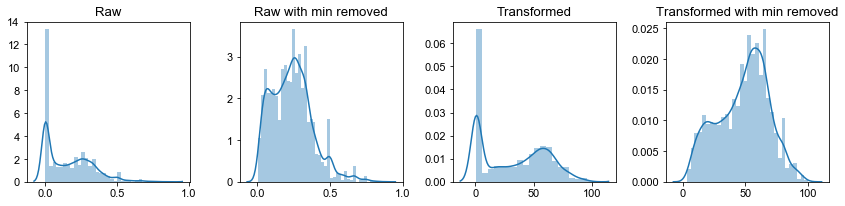

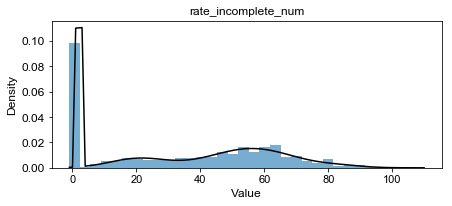

In [59]:
ftr_str = 'rate_incomplete_num'
m, g, x = independent_component(ftr_str, hist_bin=30)